<a href="https://colab.research.google.com/github/Srinivasan641/Python/blob/main/chapter_appendix-tools-for-deep-learning/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib # Import nibabel

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Corrected import for preprocessing layers
from tensorflow.keras import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [73]:
!pip install nilearn

In [74]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

In [75]:
!pip install kagglehub


In [76]:
import kagglehub
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Dataset path:", path)

Using Colab cache for faster access to the 'brats20-dataset-training-validation' dataset.
Dataset path: /kaggle/input/brats20-dataset-training-validation


In [77]:
!ls /kaggle/input/brats20-dataset-training-validation

BraTS2020_TrainingData	BraTS2020_ValidationData


Text(0.5, 1.0, 'Mask')

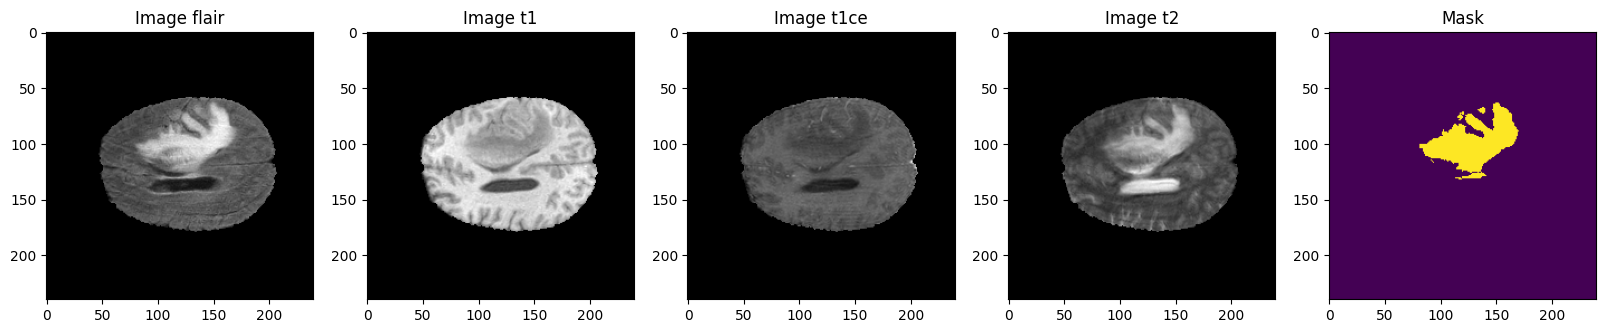

In [78]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

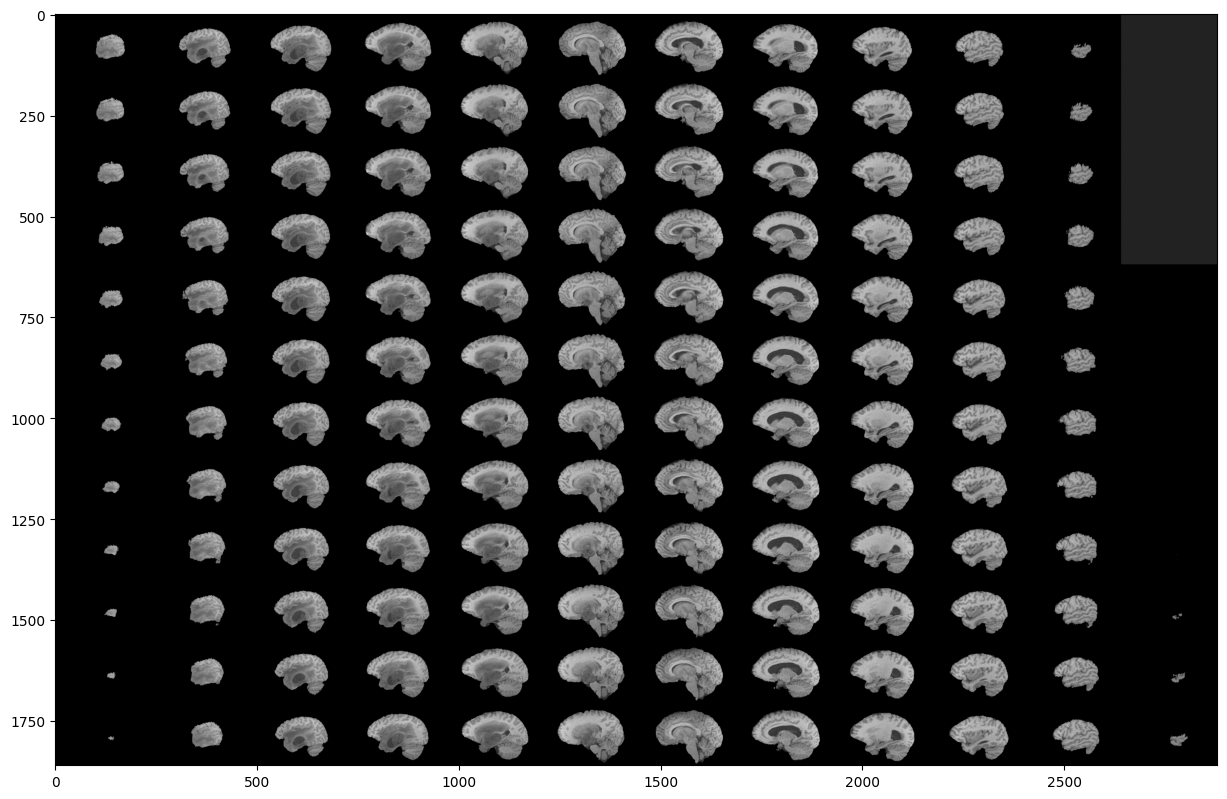

In [79]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

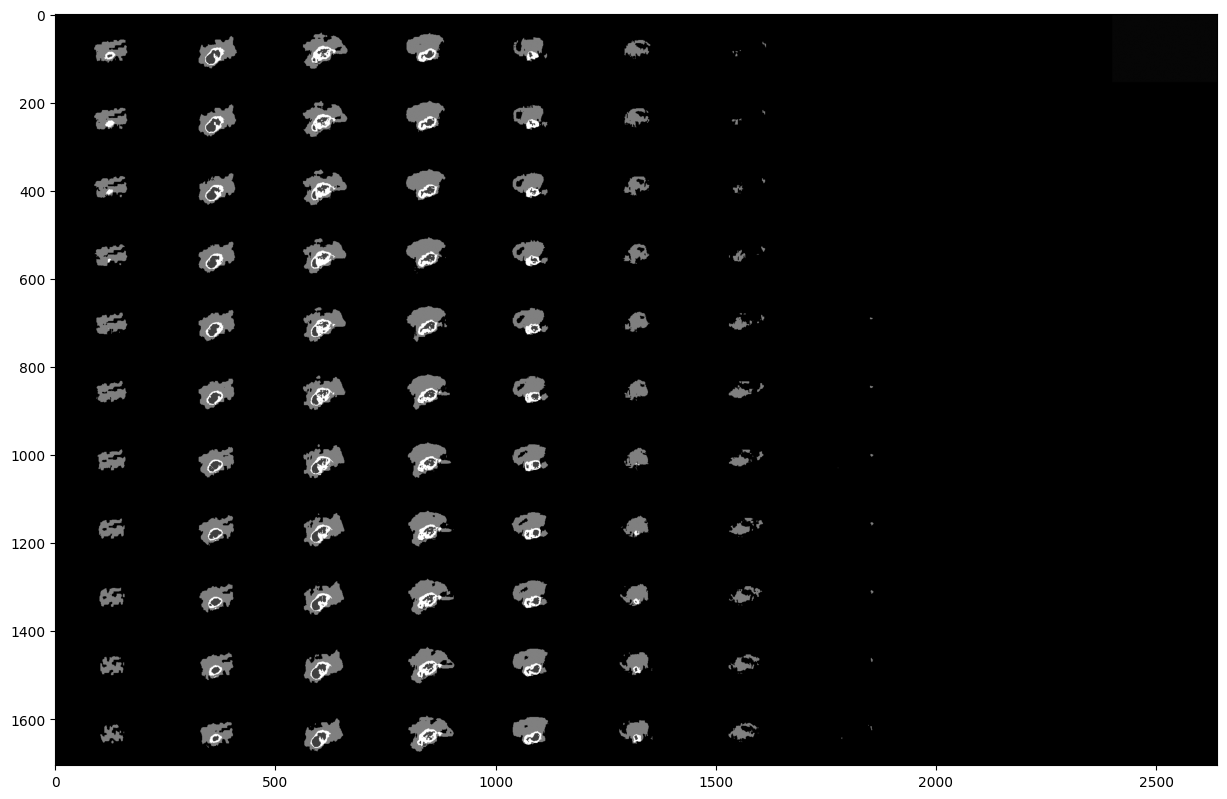

In [80]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

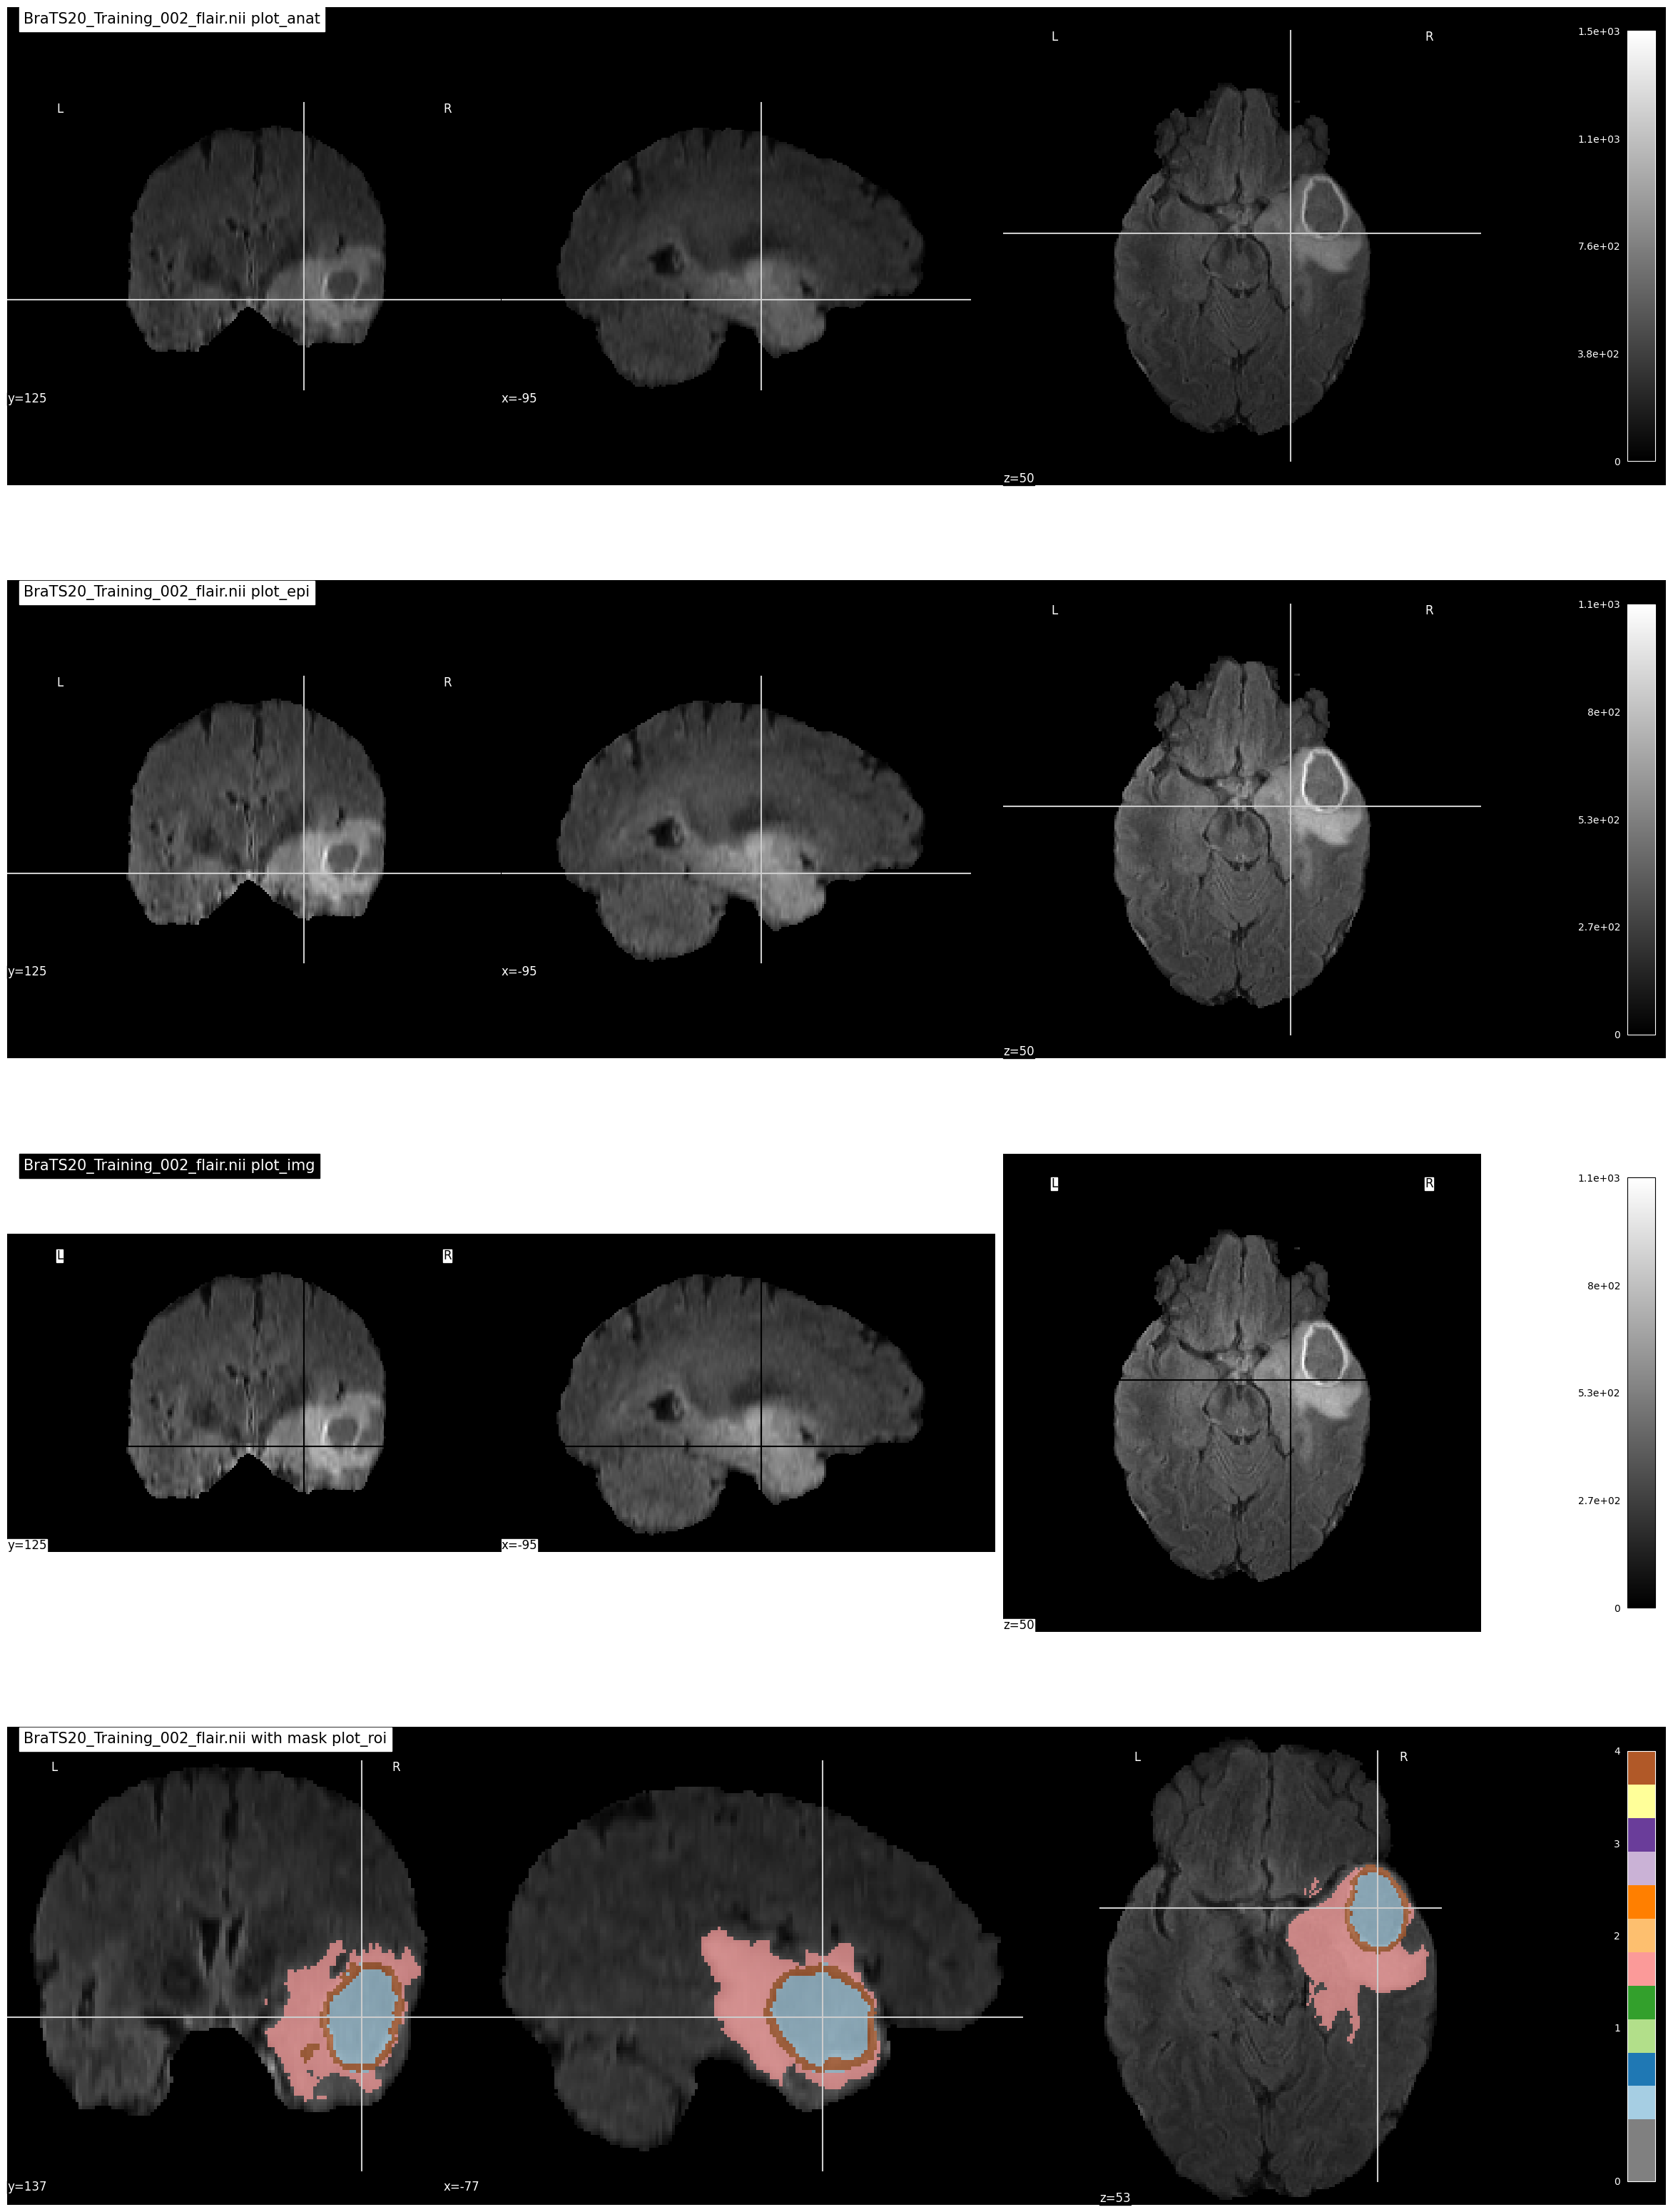

In [81]:
import nilearn.image as image
import nilearn.plotting as plotting

niimg = image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_flair.nii')
nimask = image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


plotting.plot_anat(niimg,
                title='BraTS20_Training_002_flair.nii plot_anat',
                axes=axes[0])

plotting.plot_epi(niimg,
               title='BraTS20_Training_002_flair.nii plot_epi',
               axes=axes[1])

plotting.plot_img(niimg,
               title='BraTS20_Training_002_flair.nii plot_img',
               axes=axes[2])

plotting.plot_roi(nimask,
               title='BraTS20_Training_002_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()

In [82]:
!pip install nifti2gif

In [83]:
!pip install nibabel imageio matplotlib

import nibabel as nib
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os

# Define function to save GIF from 3D volume slices
def create_gif_from_nifti(nifti_path, gif_path, slice_axis=2, start_slice=0, end_slice=None, step=1):
    img = nib.load(nifti_path)
    data = img.get_fdata()

    # Select slices based on axis (default axial slices)
    slices = []
    total_slices = data.shape[slice_axis]
    if end_slice is None or end_slice > total_slices:
        end_slice = total_slices

    for i in range(start_slice, end_slice, step):
        if slice_axis == 0:
            slice_img = data[i, :, :]
        elif slice_axis == 1:
            slice_img = data[:, i, :]
        else:
            slice_img = data[:, :, i]

        # Normalize slice for better visualization
        slice_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))
        slice_uint8 = np.uint8(slice_norm * 255)

        # Create RGB image using cmap 'gray'
        plt.imshow(slice_uint8, cmap='gray')
        plt.axis('off')

        # Save plot to a temporary buffer as PNG
        plt.savefig('temp_slice.png', bbox_inches='tight', pad_inches=0)
        plt.close()

        slices.append(imageio.imread('temp_slice.png'))

    # Save slices as GIF
    imageio.mimsave(gif_path, slices, duration=0.1)

    # Cleanup temp file
    if os.path.exists('temp_slice.png'):
        os.remove('temp_slice.png')

    print(f'GIF saved to {gif_path}')

# Example usage

TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
nifti_file = TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_flair.nii'

output_gif = './braTS20_flair_slices.gif'

create_gif_from_nifti(nifti_file, output_gif)



/tmp/ipython-input-193822404.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  slices.append(imageio.imread('temp_slice.png'))
/tmp/ipython-input-193822404.py:29: RuntimeWarning: invalid value encountered in divide
  slice_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))
/tmp/ipython-input-193822404.py:30: RuntimeWarning: invalid value encountered in cast
  slice_uint8 = np.uint8(slice_norm * 255)


GIF saved to ./braTS20_flair_slices.gif


In [84]:
!ls ./braTS20_flair_slices.gif

./braTS20_flair_slices.gif


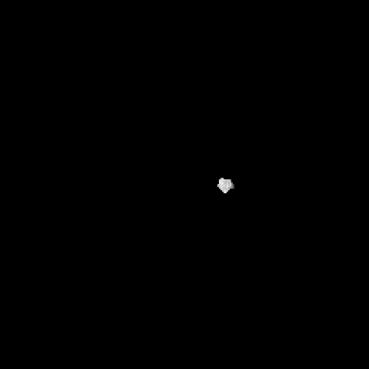

In [85]:
from IPython.display import Image, display

gif_path = './braTS20_flair_slices.gif'
display(Image(filename=gif_path))


In [86]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1]) # Use tf.reshape instead of K.flatten
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1]) # Use tf.reshape instead of K.flatten
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(K.square(y_true[:,:,:,1])) + tf.reduce_sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(K.square(y_true[:,:,:,2])) + tf.reduce_sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(K.square(y_true[:,:,:,3])) + tf.reduce_sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [87]:
IMG_SIZE=128

In [88]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

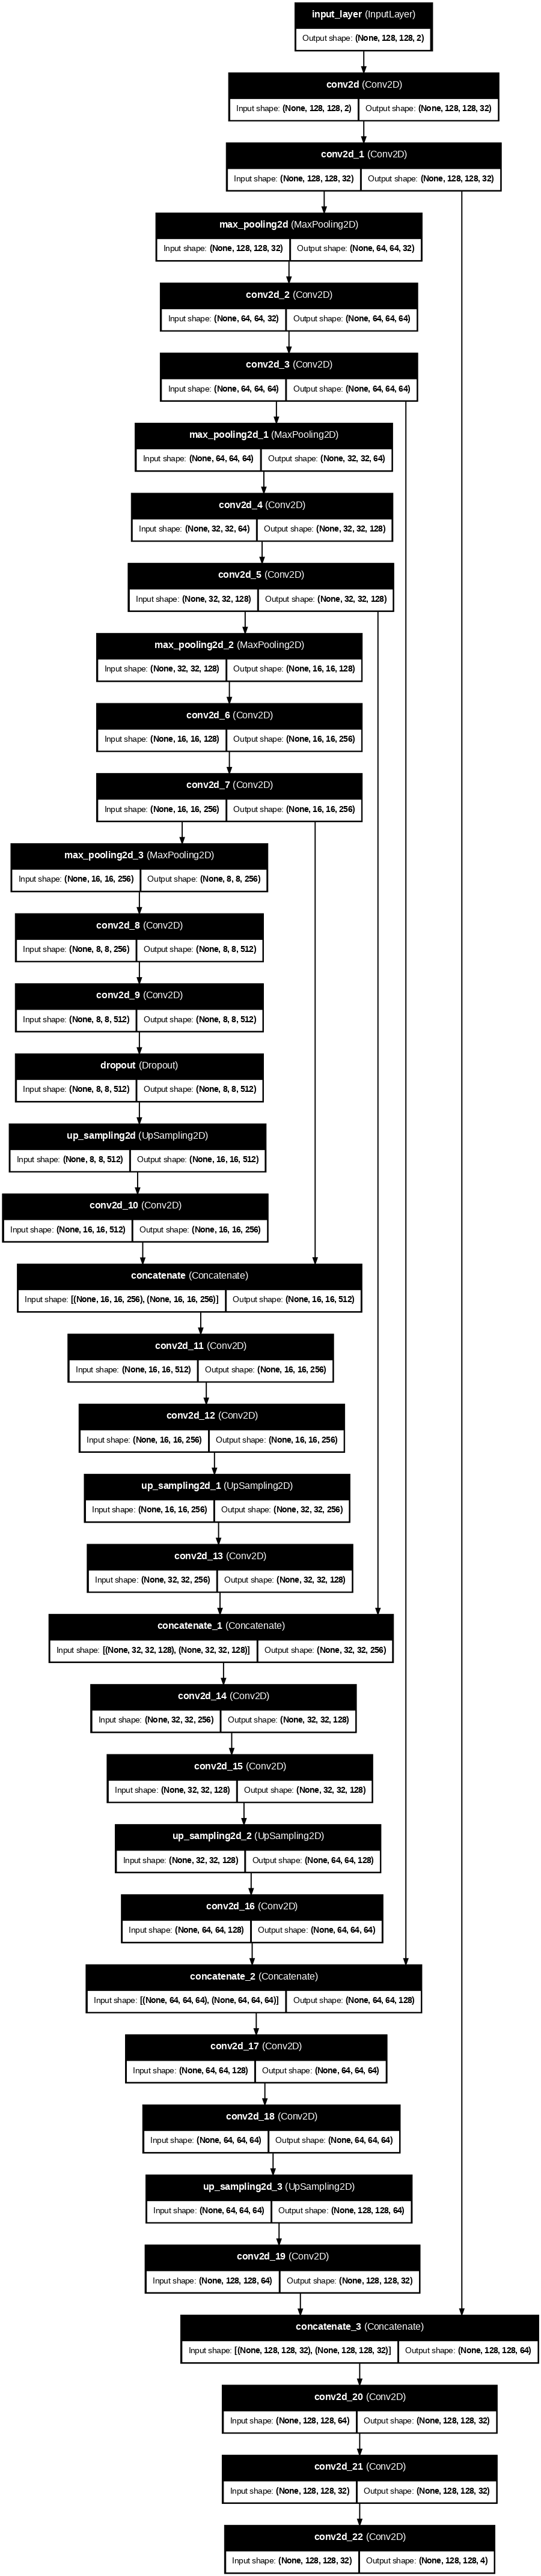

In [89]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)


In [90]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [91]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

/tmp/ipython-input-2765836405.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


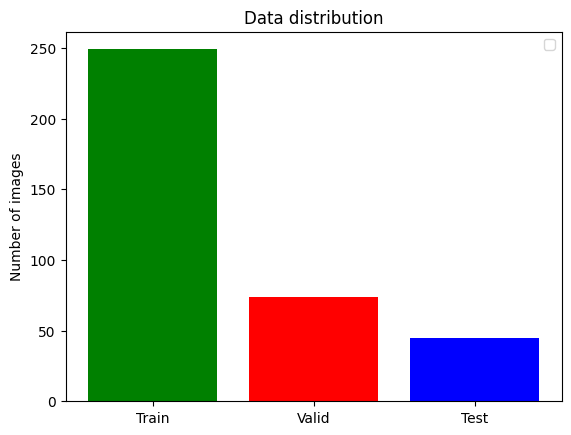

In [92]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

In [93]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
# I train by 35 epochs but for time i will use 15 epochs
history =  model.fit(training_generator,
                    epochs=15,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
model.save("3D_MRI_Brain_tumor_segmentation.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 15/249 ━━━━━━━━━━━━━━━━━━━━ 2:46 712ms/step - accuracy: 0.7458 - dice_coef: 0.1736 - dice_coef_edema: 0.0236 - dice_coef_enhancing: 0.0160 - dice_coef_necrotic: 0.0085 - loss: 1.3994 - mean_io_u: 0.4382 - precision: 0.6304 - sensitivity: 0.4497 - specificity: 0.9969

In [94]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import cv2

# Load the saved model
model = tf.keras.models.load_model("3D_MRI_Brain_tumor_segmentation.h5", custom_objects={
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
})

def preprocess_image(image_file, slice_index=None):
    # Load the NIfTI file
    img = nib.load(image_file).get_fdata()

    # Select a specific slice if needed
    if slice_index is not None:
        img = img[:, :, slice_index]

    # Resize the image to (IMG_SIZE, IMG_SIZE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize the image
    img_resized = img_resized / np.max(img_resized)

    return img_resized

def predict(image_paths, slice_index):
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, 2))

    # Process specific slices from the images
    X[0, :, :, 0] = preprocess_image(image_paths[0], slice_index)
    X[0, :, :, 1] = preprocess_image(image_paths[1], slice_index)

    # Make prediction
    pred = model.predict(X)

    return np.argmax(pred[0], axis=-1)

# Example usage
image_paths = [
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_flair.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t1ce.nii'
]

slice_index = 75  # Example slice index
prediction = predict(image_paths, slice_index)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '3D_MRI_Brain_tumor_segmentation.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import numpy as np

def get_classification(pred):
    # Get the class with the highest probability for each pixel
    class_predictions = np.argmax(pred, axis=-1)
    return class_predictions

In [ ]:
get_classification(prediction)